<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#General-imports" data-toc-modified-id="General-imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>General imports</a></span></li><li><span><a href="#Kernel-smoothing" data-toc-modified-id="Kernel-smoothing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Kernel smoothing</a></span><ul class="toc-item"><li><span><a href="#Small-sigma" data-toc-modified-id="Small-sigma-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Small sigma</a></span></li></ul></li><li><span><a href="#Bigger-sigma" data-toc-modified-id="Bigger-sigma-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Bigger sigma</a></span><ul class="toc-item"><li><span><a href="#True-data" data-toc-modified-id="True-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>True data</a></span></li></ul></li><li><span><a href="#Firing-rate-and-baseline" data-toc-modified-id="Firing-rate-and-baseline-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Firing rate and baseline</a></span><ul class="toc-item"><li><span><a href="#Testando-na-mão" data-toc-modified-id="Testando-na-mão-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Testando na mão</a></span></li></ul></li><li><span><a href="#Comparações" data-toc-modified-id="Comparações-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Comparações</a></span><ul class="toc-item"><li><span><a href="#Multiplos-paddings" data-toc-modified-id="Multiplos-paddings-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Multiplos paddings</a></span></li></ul></li></ul></div>

# General imports 

In [1]:
import os
os.chdir('../../')
from spikelearn.data.preprocessing import kernel_smooth
from spikelearn.data import io, SHORTCUTS
from spikelearn.data.selection import select, to_feature_array

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# Kernel smoothing

In [2]:
BASELINE = -500
DSET_PARAMS = {'wide_smoothed' : { 'sigma' : 100,
                                  'bin_size' : 100},

              'narrow_smoothed' : { 'sigma' : 50,
                                    'bin_size' : 100},

              'wide_smoothed_viz' : { 'sigma' : 100,
                                      'bin_size' : 20},

              'narrow_smoothed_viz' : { 'sigma' : 50,
                                        'bin_size' : 20}
                }

In [3]:
epoch = io.load('DRRD 8', 'epoched_spikes')

In [242]:
def pretty_neurons(spike_vector=None, smooth=None, times=None,
                    n_neurons=8, rate = 1, tmin = -.5, tmax=10,
                    spacing = 1, palette='Set2', bin_fill=None,
                    alpha_multiplier = 'auto', alpha_power = 1/2,
                    binpalette='plasma', bin_sep=None, fig_kwargs=None):
    """ Plots multiple point processes in parallel lines.

    Parameters
    ----------
    spike_vector : array-like (n_neurons, )
        Each row contains the spike times of one unit, and will be plotted in
        one line. 

    show_spikes : bool, default True
        Which to show spikes or only smoothed activity.
        If True and sigma > 0, plot will be empty.

    sigma : int
        Width of gaussian kernel to smooth spike-series.

    n_neurons : int
        Number of units to be generated.
        Is overwritten by spike_vector

    rate : float
        Firing rate of each generated unit.
        Active only if spike_vector is None

    tmax : float
        Maximum time until which to simulate activity, in seconds.
        Active only if spike_vector is None

    Other Parameters
    ----------------
    spacing : float, default 1
        Vertical distance between each baseline

    palette : string
        If len>1, names a Seabon color_palette
        If char (len==1), is the color of all neurons

    bin_fill : tuple, (int, int)
        Position (x,y) of bin to be color-filled.
        According to the value of the binning.

    alpha_multiplier : float or 'auto'
        How much to multiply each bin fill alpha value.
        'auto' selects a number such that the maximum is one.

    alpha_power : float
        How much to exponentiate each bin's firing rate to get the alpha.
        Smaller values approximate big values and decrease difference.

    bin_sep: int
        How much vertical separators to use in the bin separation.

    binpalette : str
        Which palette to
        Note: It does not correspond to bin filling,
        only to vertical separators.


    """
    if alpha_multiplier is 'auto':
        alpha_multiplier = 1/(max(list(map(np.max, smooth))))
    
    # Define color of each unit
    n_neurons = spike_vector.shape[0] if spike_vector is not None else smooth.shape[0]
    assert type(palette) is str
    if len(palette) > 1:
        neuroncolors = sns.palettes.color_palette(palette,n_neurons)
    else:
        neuroncolors = palette*n_neurons

    ## Plotting per se
    fig=plt.figure(**fig_kwargs if fig_kwargs is not None else {})
    ax=plt.subplot(1,1,1)

    # Base horizontal lines
    ax.hlines((spacing)*np.arange(n_neurons), tmin,tmax,colors=neuroncolors);

    # Point process
    if spike_vector is not None:
        for i in range(n_neurons):
            ax.vlines(spike_vector[i][:],(spacing)*i,(spacing)*i+.3, colors=neuroncolors[i], linewidth=1)

    # Smoothed activity
    if smooth is not None:
        for i in range(smooth.shape[0]):
            plt.plot(times[i],smooth[i]+(spacing)*i,linewidth=1,color = neuroncolors[i])
        
    # Vertical separators
    if bin_sep is not None:
        bincmap = sns.palettes.color_palette(binpalette,max(list(map(len, times))))
        plt.vlines(times[0][:bin_sep],-1,n_neurons,linewidth=8,colors=bincmap,linestyle='-')
    # Each bin value in its color alpha
    if bin_fill is not None:
        for j in range(bin_fill[0]):
            for i in range(bin_fill[1]):
                alpha = (smooth[j][1+i]*alpha_multiplier)**alpha_power
                plt.fill_between(times[0][i:i+2],j,j+1,color = neuroncolors[j], alpha=alpha)
    # Aesthetics
    ax.set_yticks((spacing)*np.arange(n_neurons)+(spacing)*.5)
    ax.set_yticklabels(['Neuron %d'%i for i in range(1,n_neurons+1)],fontsize=12)
    ax.set_xlim(tmin,tmax); 
    if smooth is not None:
        ax.set_ylim(-0.2,max(smooth[-1][:].max()+n_neurons,(spacing)*n_neurons+.2))
    else :
        ax.set_ylim(-0.2,(spacing)*n_neurons+.2)
    return fig


In [5]:
from spikelearn.data.preprocessing import kernel_smooth

In [6]:
%load_ext autoreload
%autoreload 2

In [74]:
%%time
edges = (0,1000)
size = np.full((969,  4), np.nan)
for position in range(0,969):
    one_spike = np.random.randint(position+1, position+30, 5)
    for j, binsize in enumerate([10]):
        for k, sigma in enumerate([10, 20, 50, 100]):
            size[position-1, k] = kernel_smooth(one_spike, sigma, edges, bin_size=binsize,border_correction=False, padding='symmetric')[0].sum()

CPU times: user 4.26 s, sys: 4 ms, total: 4.26 s
Wall time: 4.45 s


In [35]:
import scipy.stats as st

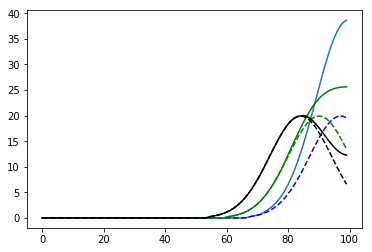

In [76]:
plt.plot(kernel_smooth(one_spike, sigma, edges, bin_size=binsize,border_correction=False, padding='symmetric')[0])
plt.plot(kernel_smooth(one_spike, sigma, edges, bin_size=binsize,border_correction=False)[0], 'b--')

plt.plot(kernel_smooth(one_spike-70, sigma, edges, bin_size=binsize, border_correction=False, padding='symmetric')[0],'g')
plt.plot(kernel_smooth(one_spike-70, sigma, edges, bin_size=binsize,border_correction=False)[0], 'g--')

plt.plot(kernel_smooth(one_spike-130, sigma, edges, bin_size=binsize,border_correction=False, padding='symmetric')[0],'k')
plt.plot(kernel_smooth(one_spike-130, sigma, edges, bin_size=binsize,border_correction=False)[0], 'k--')

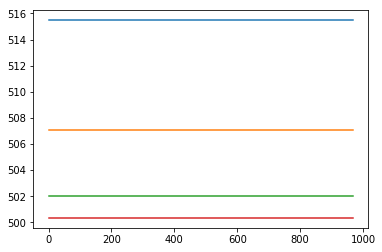

In [77]:
plt.plot(size[:,0])
plt.plot(size[:,1])
plt.plot(size[:,2])
plt.plot(size[:,3])

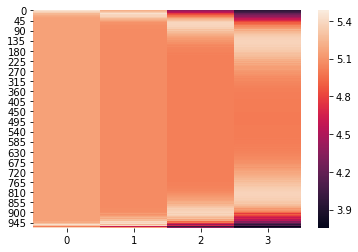

In [85]:
sns.heatmap(size)

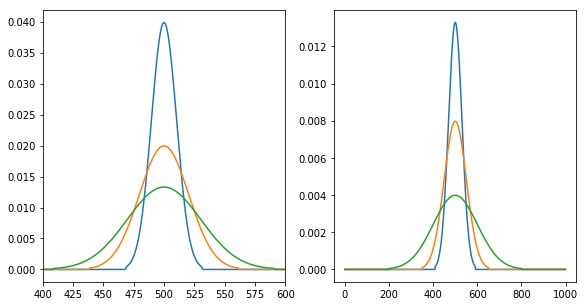

In [11]:
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
for sigma in [10,20,30]:
    y, x = kernel_smooth(one_spike, sigma, edges)
    plt.plot(x,y)
plt.xlim(400,600)

plt.subplot(1,4,2)
for sigma in [30,50,100]:
    y, x = kernel_smooth(one_spike, sigma, edges)
    plt.plot(x,y)



## Small sigma

In [30]:
label = 'DRRD 8'
spike_vector = select(io.load(label, 'epoched_spikes'), is_selected=True)
firing_rates = io.load(label, 'narrow_smoothed')

(0, 1)

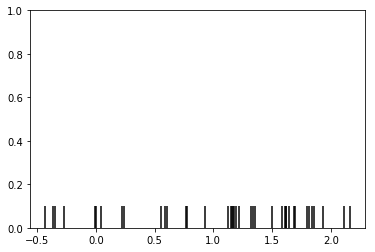

In [64]:
fig, ax = plt.subplots()

ax.vlines(spike_vector.with_baseline[1].iloc[3], 0, .1)
ax.set_ylim(0,1)
# spike_vector.trial_time[1].iloc[:2].apply(lambda s: plt.vlines(s, 0,1))

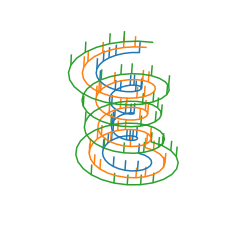

In [194]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

mpl.rcParams['legend.fontsize'] = 10
fig = plt.figure(figsize=(4,4))
ax = fig.gca(projection='3d')

theta = np.linspace(-4 * np.pi, 4 * np.pi, 100)
N=100


for R, color in zip([2, 4.5, 7], sns.color_palette()):
    
    z = np.linspace(-2, 2, N) 
    r = z**2 + R
    x = r * np.sin(theta)
    y = r * np.cos(theta)

    rand = np.random.exponential(.9, N)**2 < .2*abs(z)
    ax.plot(x, y, z, color=color)
    ax.quiver(x[rand], y[rand], z[rand], .1,.1,.4,arrow_length_ratio=0, color=color)
    ax.set_axis_off()
plt.savefig('reports/figures/raw_data.svg', transparent=True, bbox='tight')

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/ipykernel/__main__.py:65: RuntimeWarning: divide by zero encountered in double_scalars


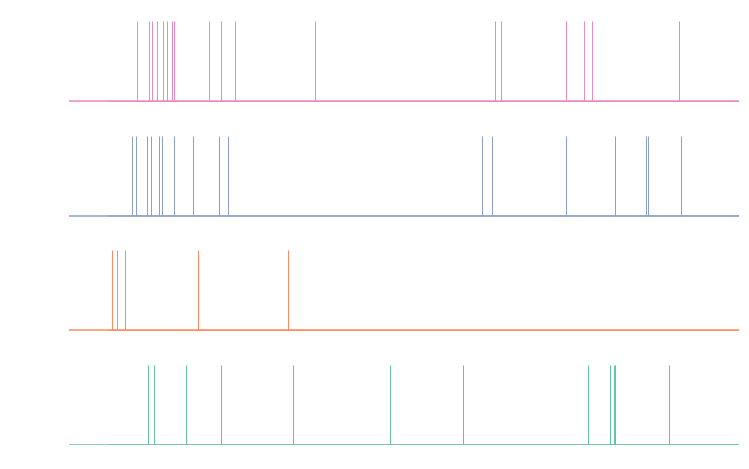

In [232]:
TRIAL = 140
smk = spike_vector.loc[TRIAL].with_baseline.apply(lambda x: kernel_smooth(x*1000, 10, (-500,1750)))
smk = pd.DataFrame(smk.tolist())

pretty_neurons(spike_vector=spike_vector.loc[TRIAL].with_baseline.values, rate = 1, tmin = -.6,tmax=spike_vector.loc[TRIAL,'duration'].values[0]+.1,
                   smooth=smk[0].values*0, times = smk[1].values/1000, fig_kwargs={'figsize':(12,8)});
plt.ylim(0,3.8)
plt.axis('off');
plt.savefig('reports/figures/epoched_%d.svg'%TRIAL, transparent=True, bbox='tight')

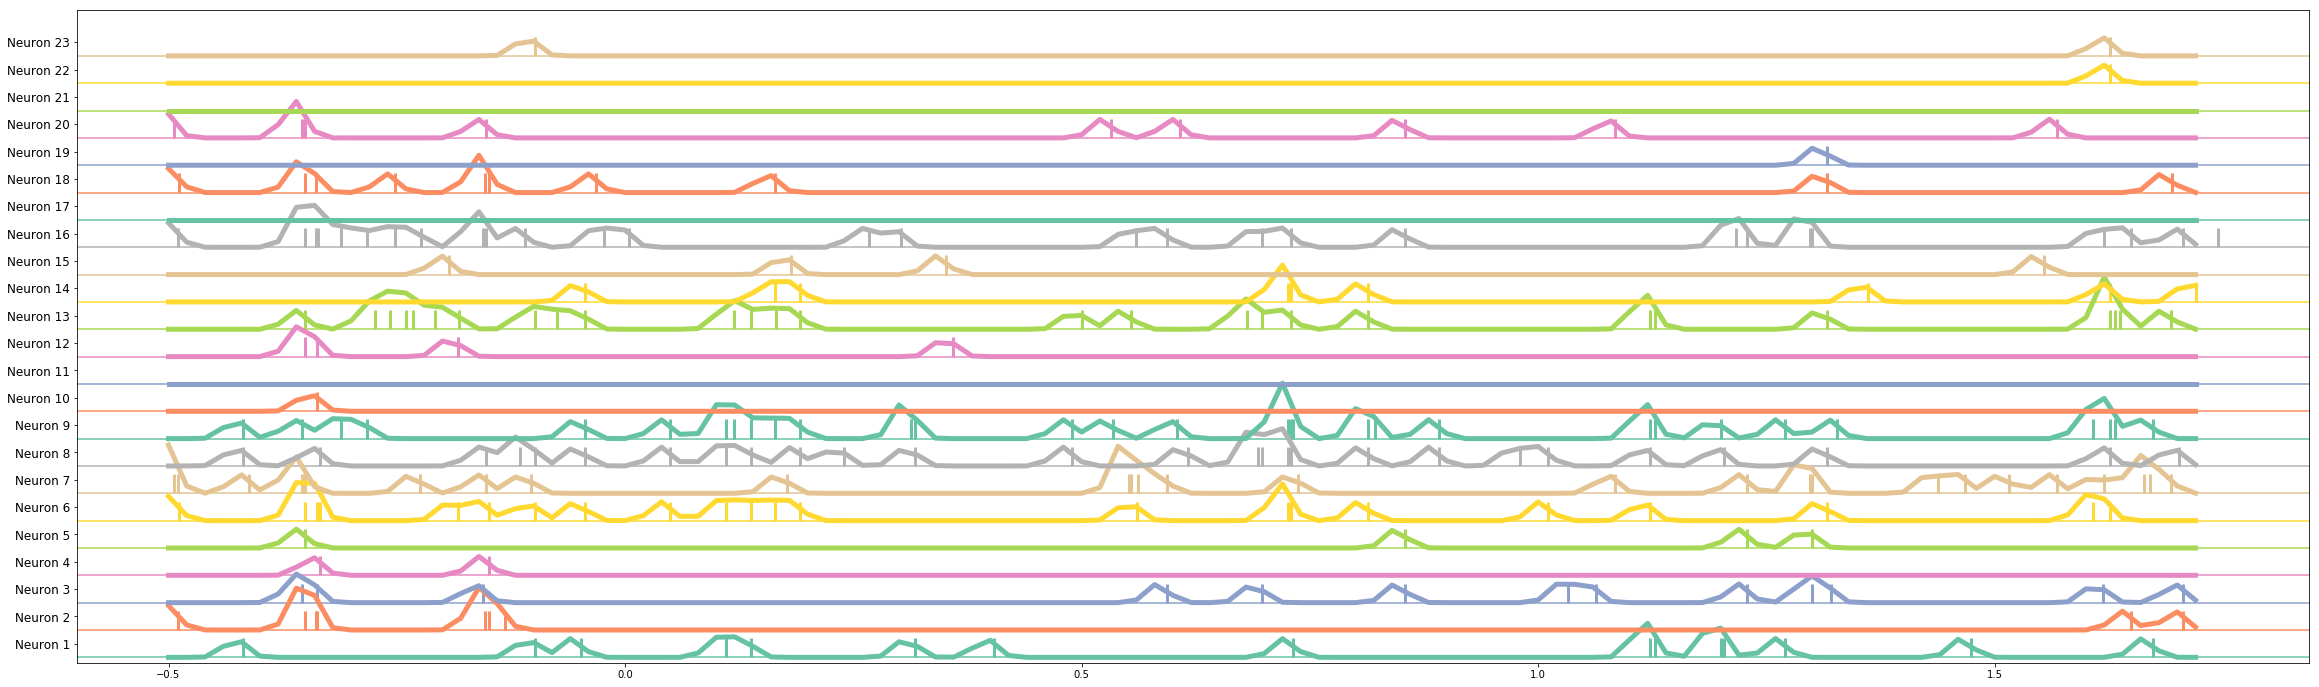

In [14]:
smk = spike_vector.loc[TRIAL].with_baseline.apply(lambda x: kernel_smooth(x*1000, sigma = 10, edges = (-500,1750), bin_size=20))
smk = pd.DataFrame(smk.tolist())

TRIAL = 130
pretty_neurons(spike_vector=spike_vector.loc[TRIAL].with_baseline.values, rate = 1, tmin = -.6,tmax=spike_vector.loc[TRIAL,'duration'].values[0]+.1,
                   smooth=smk[0].values, times = smk[1].values/1000, fig_kwargs={'figsize':(40,12)});

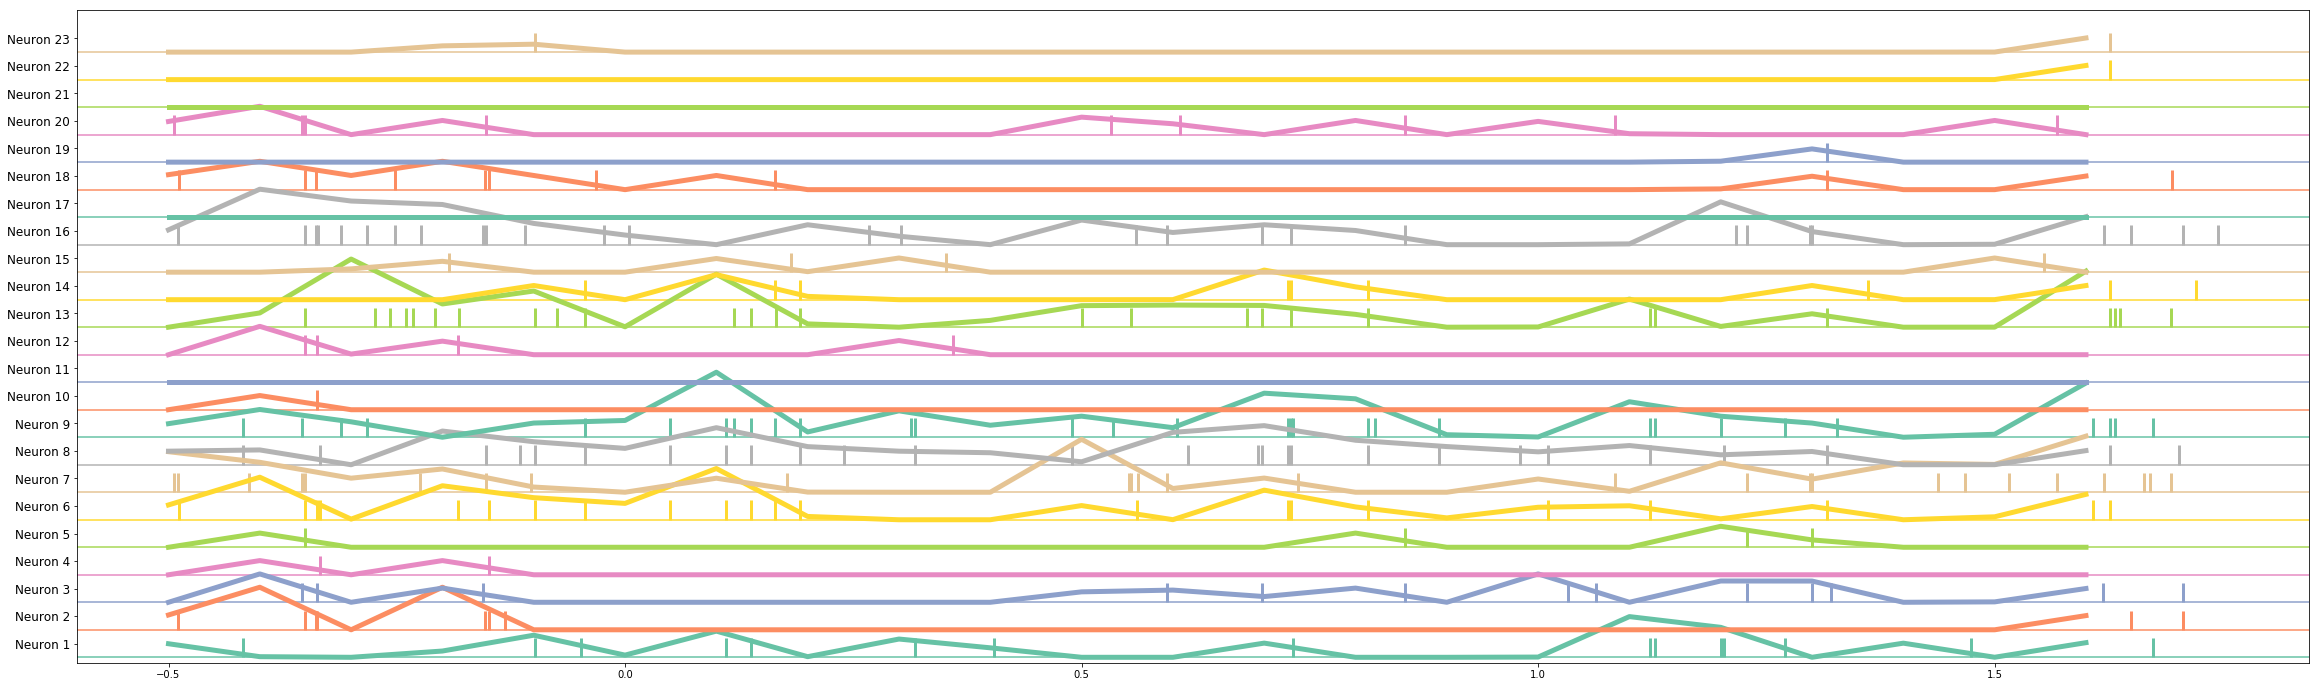

In [15]:
smk = spike_vector.loc[TRIAL].with_baseline.apply(lambda x: kernel_smooth(x*1000, sigma = 10, edges = (-500,1750), bin_size=100))
smk = pd.DataFrame(smk.tolist())

TRIAL = 130
pretty_neurons(spike_vector=spike_vector.loc[TRIAL].with_baseline.values, rate = 1, tmin = -.6,tmax=spike_vector.loc[TRIAL,'duration'].values[0]+.1,
                   smooth=smk[0].values/2, times = smk[1].values/1000, fig_kwargs={'figsize':(40,12)});

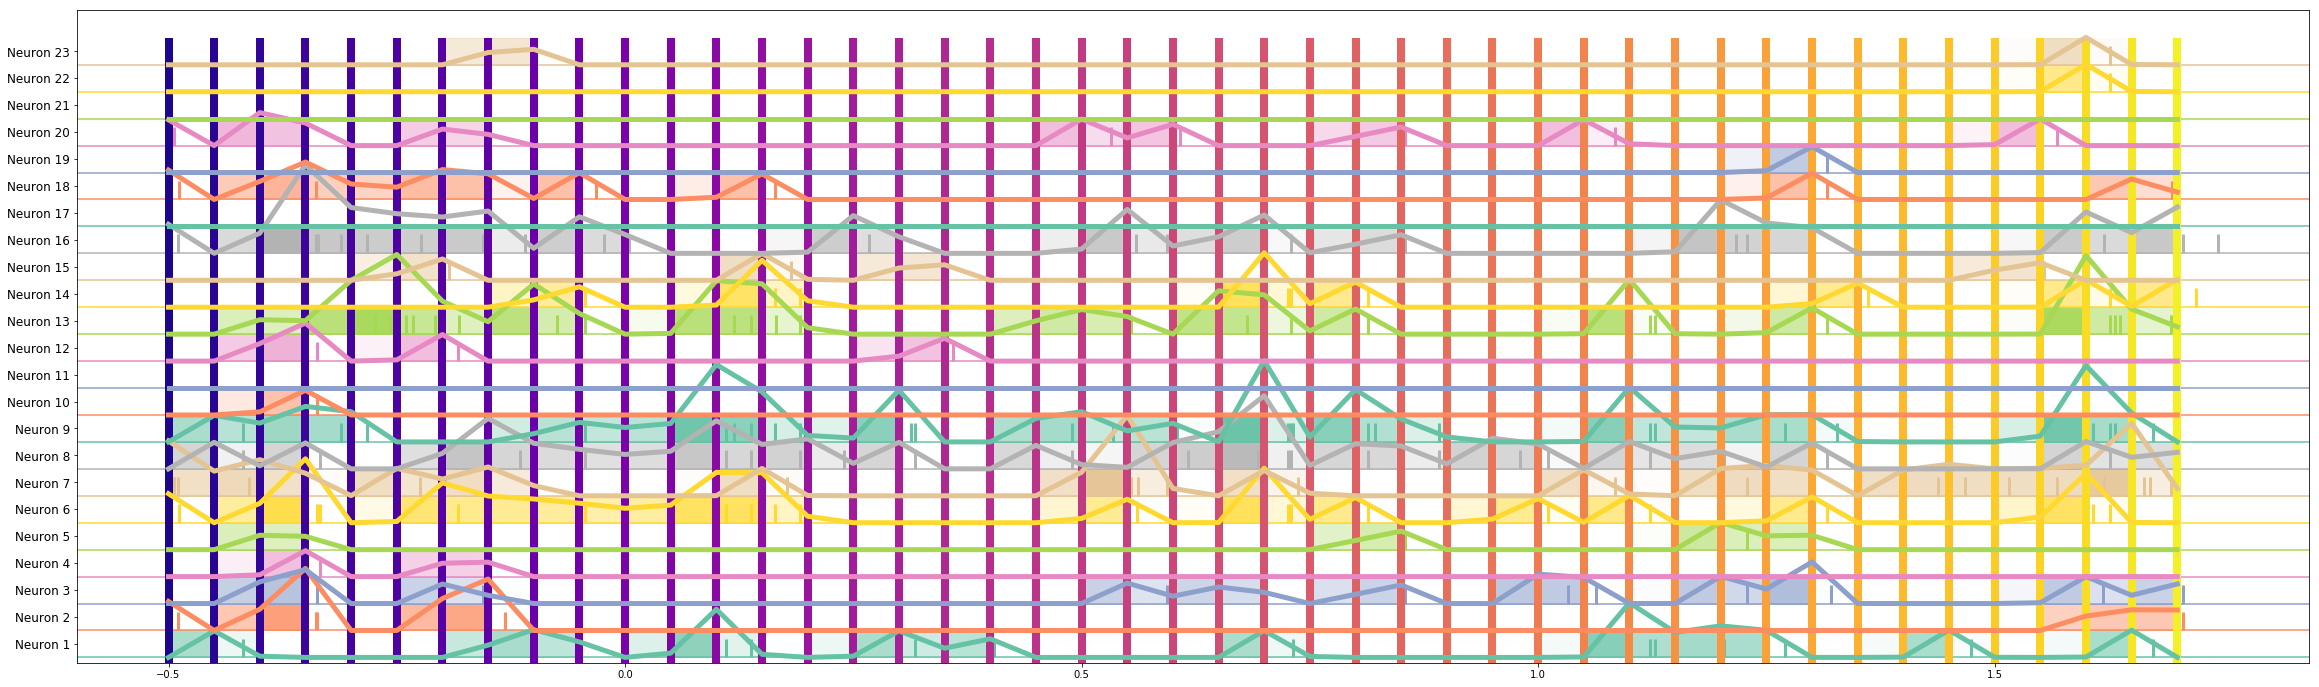

In [16]:
smk = spike_vector.loc[TRIAL].with_baseline.apply(lambda x: kernel_smooth(x*1000, sigma = 10, edges = (-500,1750), bin_size=50))
smk = pd.DataFrame(smk.tolist())

TRIAL = 130
pretty_neurons(spike_vector=spike_vector.loc[TRIAL].with_baseline.values, rate = 1, tmin = -.6,tmax=spike_vector.loc[TRIAL,'duration'].values[0]+.1,
                   smooth=smk[0].values, times = smk[1].values/1000, fig_kwargs={'figsize':(40,12)}, bin_sep=50, bin_fill=(23,44));

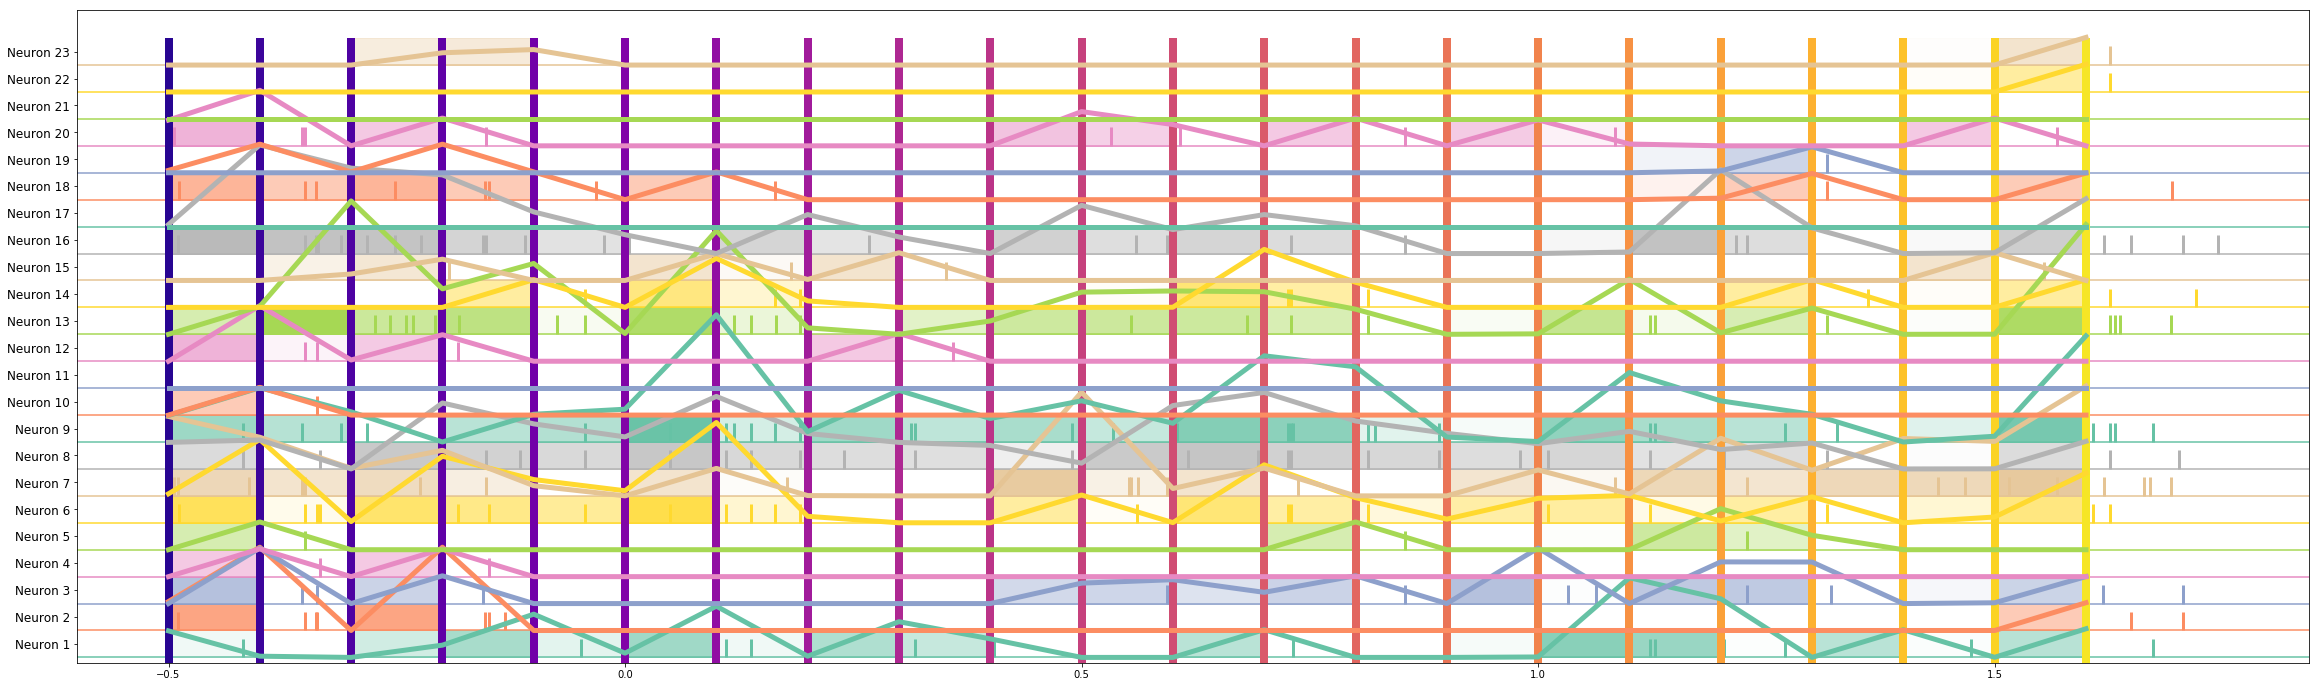

In [17]:
smk = spike_vector.loc[TRIAL].with_baseline.apply(lambda x: kernel_smooth(x*1000, sigma = 10, edges = (-500,1750), bin_size=100))
smk = pd.DataFrame(smk.tolist())

TRIAL = 130
pretty_neurons(spike_vector=spike_vector.loc[TRIAL].with_baseline.values, rate = 1, tmin = -.6,tmax=spike_vector.loc[TRIAL,'duration'].values[0]+.1,
                   smooth=smk[0].values, times = smk[1].values/1000, fig_kwargs={'figsize':(40,12)}, bin_sep=22, bin_fill=(23,21));

# Bigger sigma

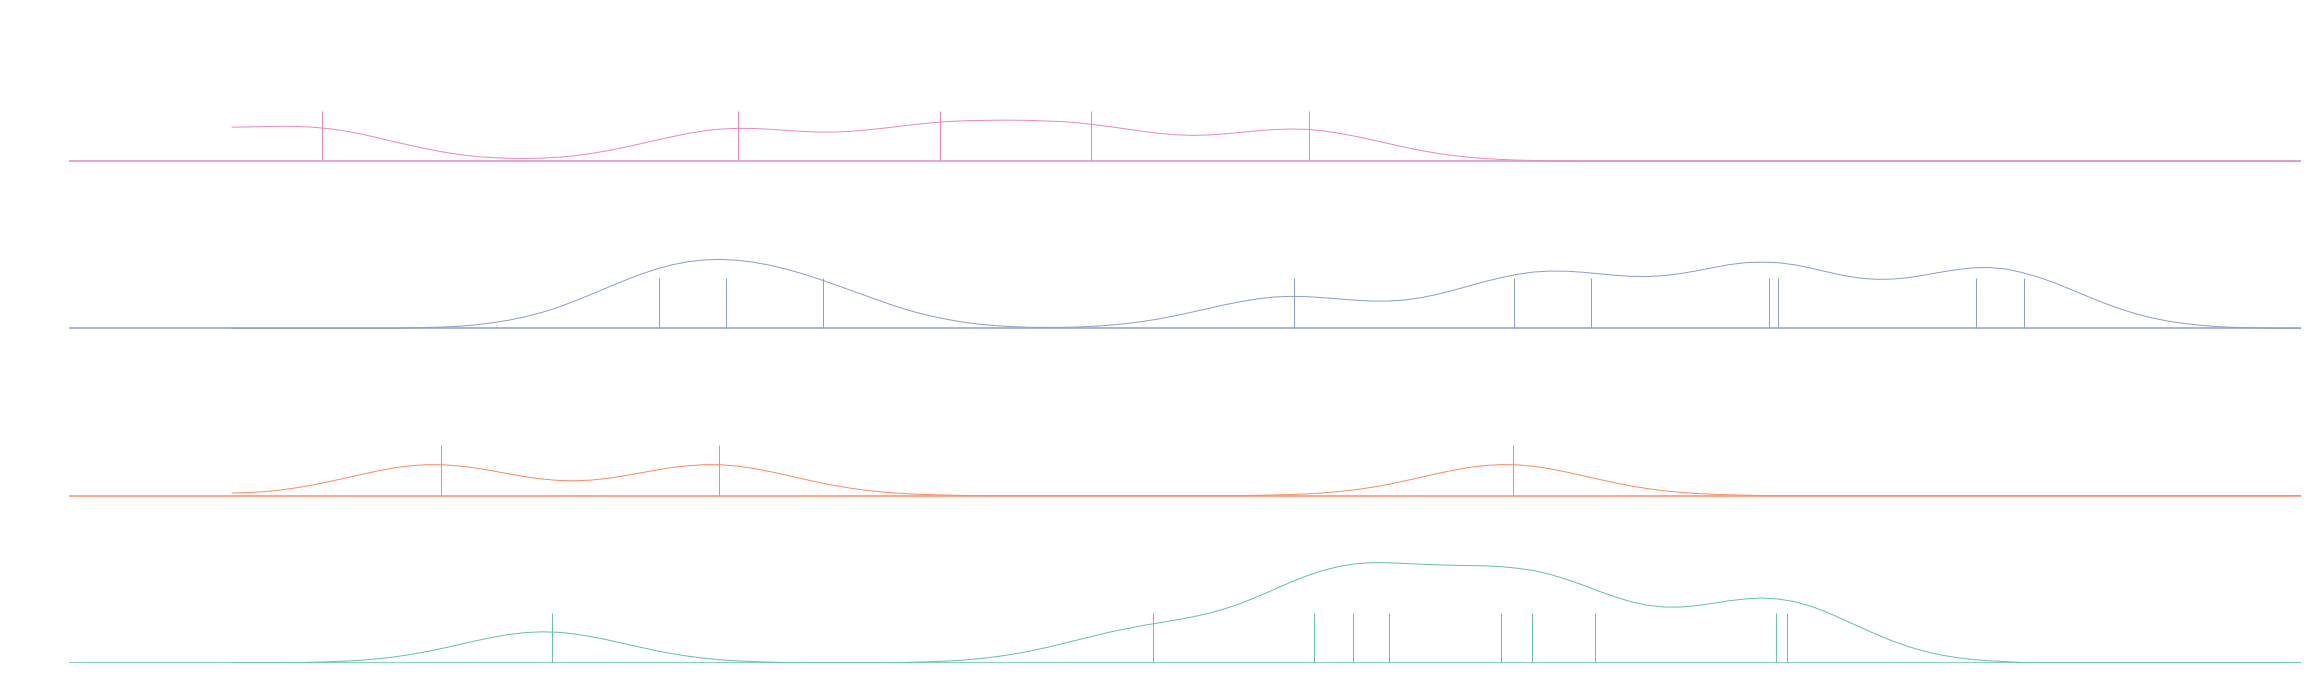

In [248]:
TRIAL = 130
smk = spike_vector.loc[TRIAL].with_baseline.apply(lambda x: kernel_smooth(x*1000, sigma = 50, edges = (-500,1750), bin_size=10))
smk = pd.DataFrame(smk.tolist())

pretty_neurons(spike_vector=spike_vector.loc[TRIAL].with_baseline.values, rate = 1, tmin = -.6,tmax=spike_vector.loc[TRIAL,'duration'].values[0]+.1,
                   smooth=smk[0].values/43, times = smk[1].values/1000, fig_kwargs={'figsize':(40,12)}, bin_sep=0);
plt.ylim(0,3.9)
plt.axis('off');
plt.savefig('reports/figures/smoothed_%d.svg'%TRIAL, transparent=True, bbox='tight')

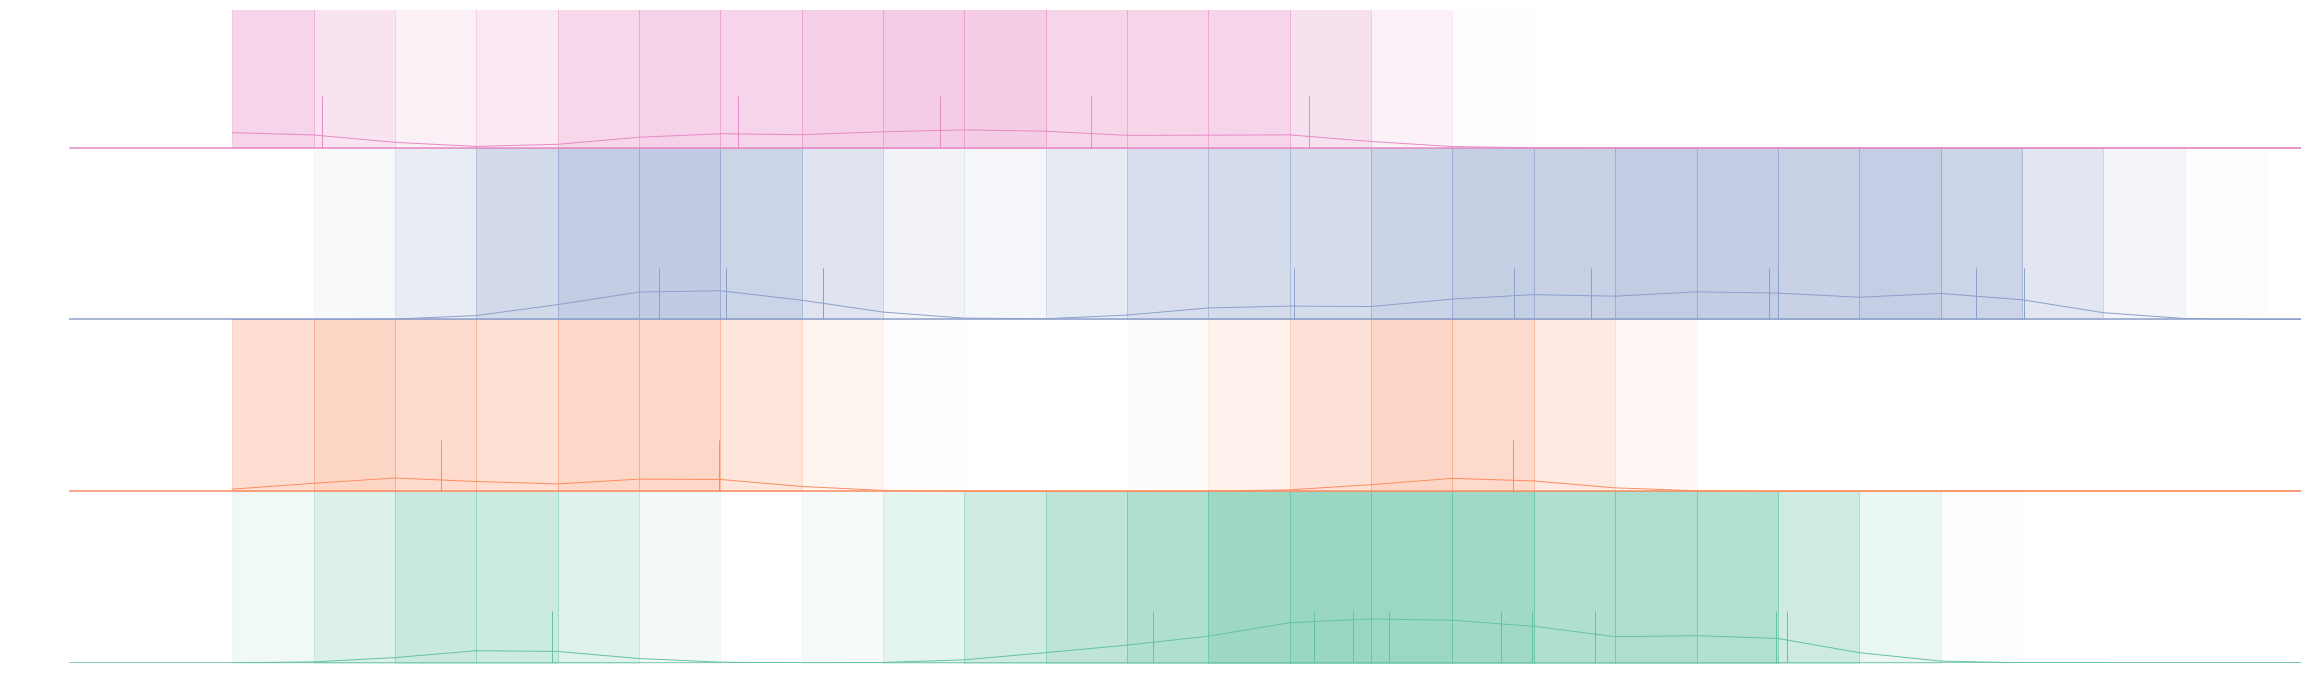

In [256]:
TRIAL = 130
smk = spike_vector.loc[TRIAL].with_baseline.apply(lambda x: kernel_smooth(x*1000, sigma = 50, edges = (-500,1750), bin_size=50))
smk = pd.DataFrame(smk.tolist())

pretty_neurons(spike_vector=spike_vector.loc[TRIAL].with_baseline.values, rate = 1, tmin = -.6,tmax=spike_vector.loc[TRIAL,'duration'].values[0]+.1,
                   smooth=smk[0].values/100, times = smk[1].values/1000, fig_kwargs={'figsize':(40,12)}, bin_sep=0, bin_fill=(4,42));
plt.ylim(0,3.8)
plt.axis('off');
plt.savefig('reports/figures/binned_%d.svg'%TRIAL, transparent=False, bbox='tight')

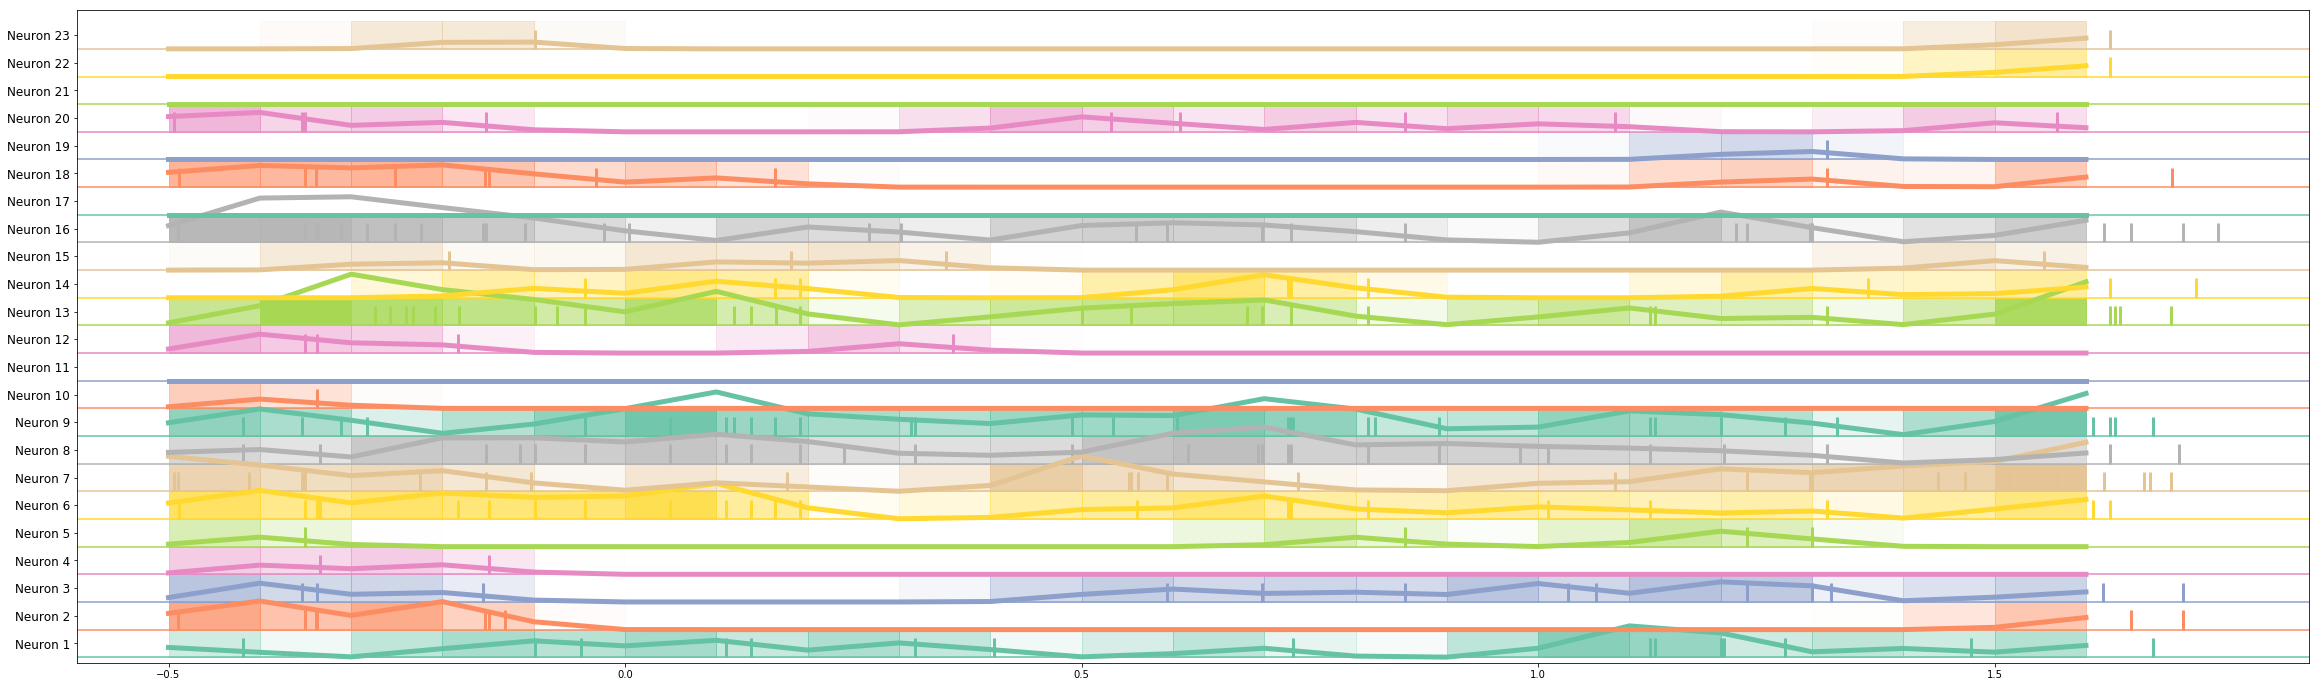

In [19]:
smk = spike_vector.loc[TRIAL].with_baseline.apply(lambda x: kernel_smooth(x*1000, sigma = 50, edges = (-500,1750), bin_size=100))
smk = pd.DataFrame(smk.tolist())

pretty_neurons(spike_vector=spike_vector.loc[TRIAL].with_baseline.values, rate = 1, tmin = -.6,tmax=spike_vector.loc[TRIAL,'duration'].values[0]+.1,
                   smooth=smk[0].values/2, times = smk[1].values/1000, fig_kwargs={'figsize':(40,12)}, bin_sep=0, bin_fill=(23,21));

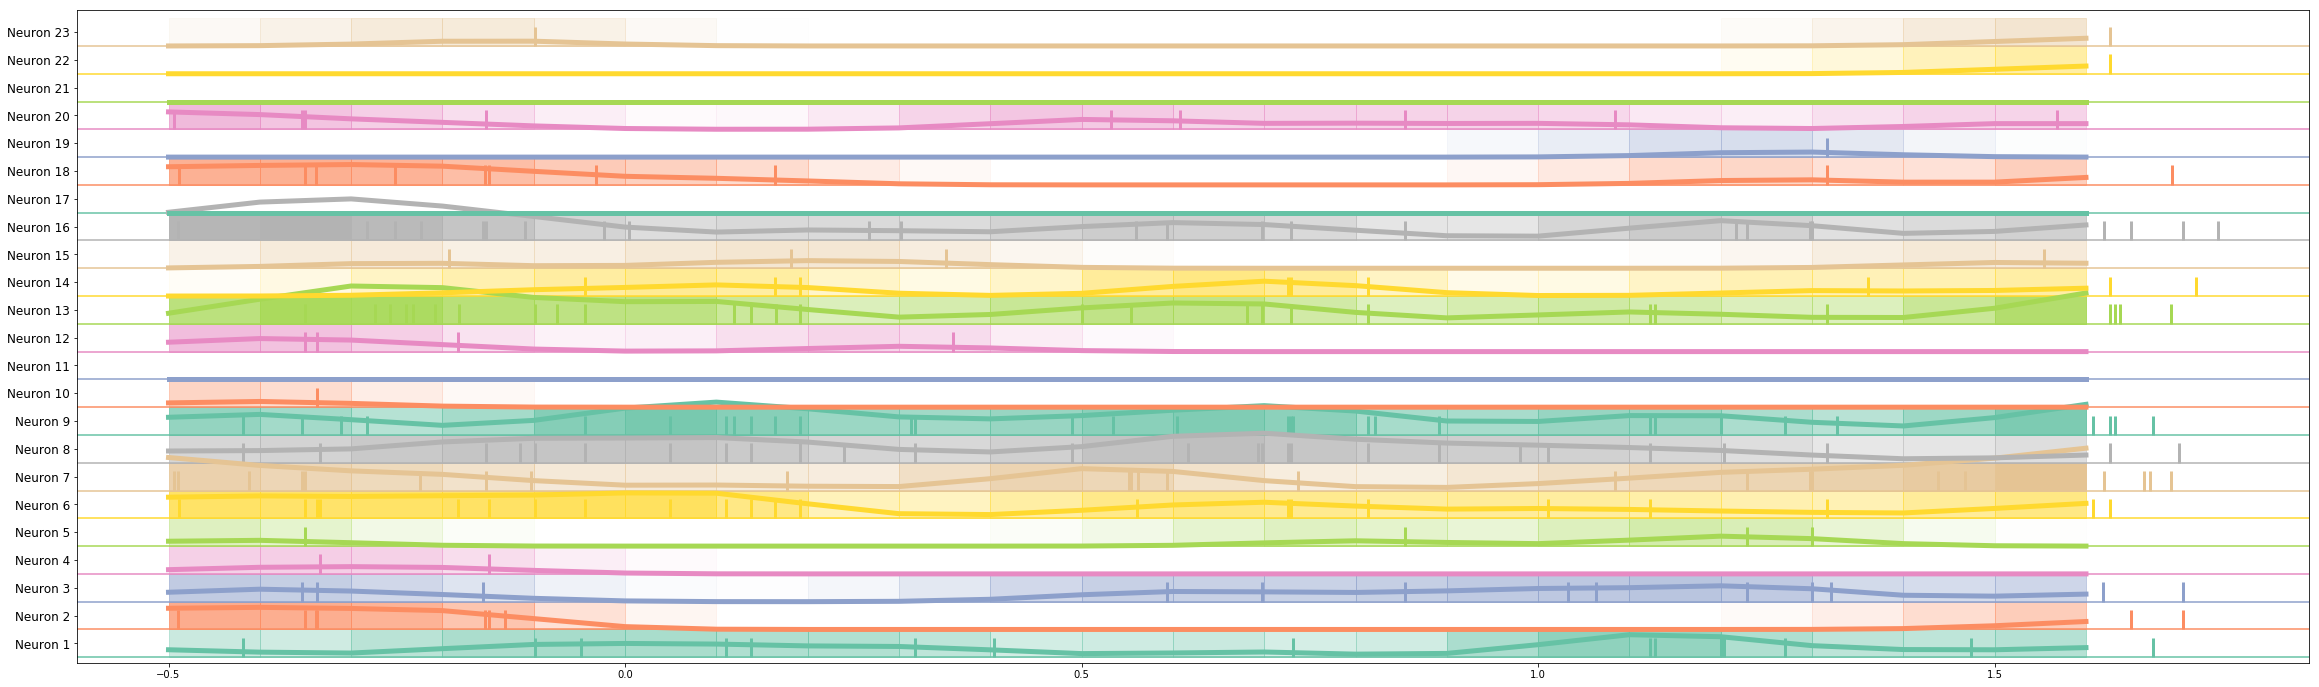

In [20]:
smk = spike_vector.loc[TRIAL].with_baseline.apply(lambda x: kernel_smooth(x*1000, sigma = 100, edges = (-500,1750), bin_size=100))
smk = pd.DataFrame(smk.tolist())

pretty_neurons(spike_vector=spike_vector.loc[TRIAL].with_baseline.values, rate = 1, tmin = -.6,tmax=spike_vector.loc[TRIAL,'duration'].values[0]+.1,
                   smooth=smk[0].values/2, times = smk[1].values/1000, fig_kwargs={'figsize':(40,12)}, bin_sep=0, bin_fill=(23,21));

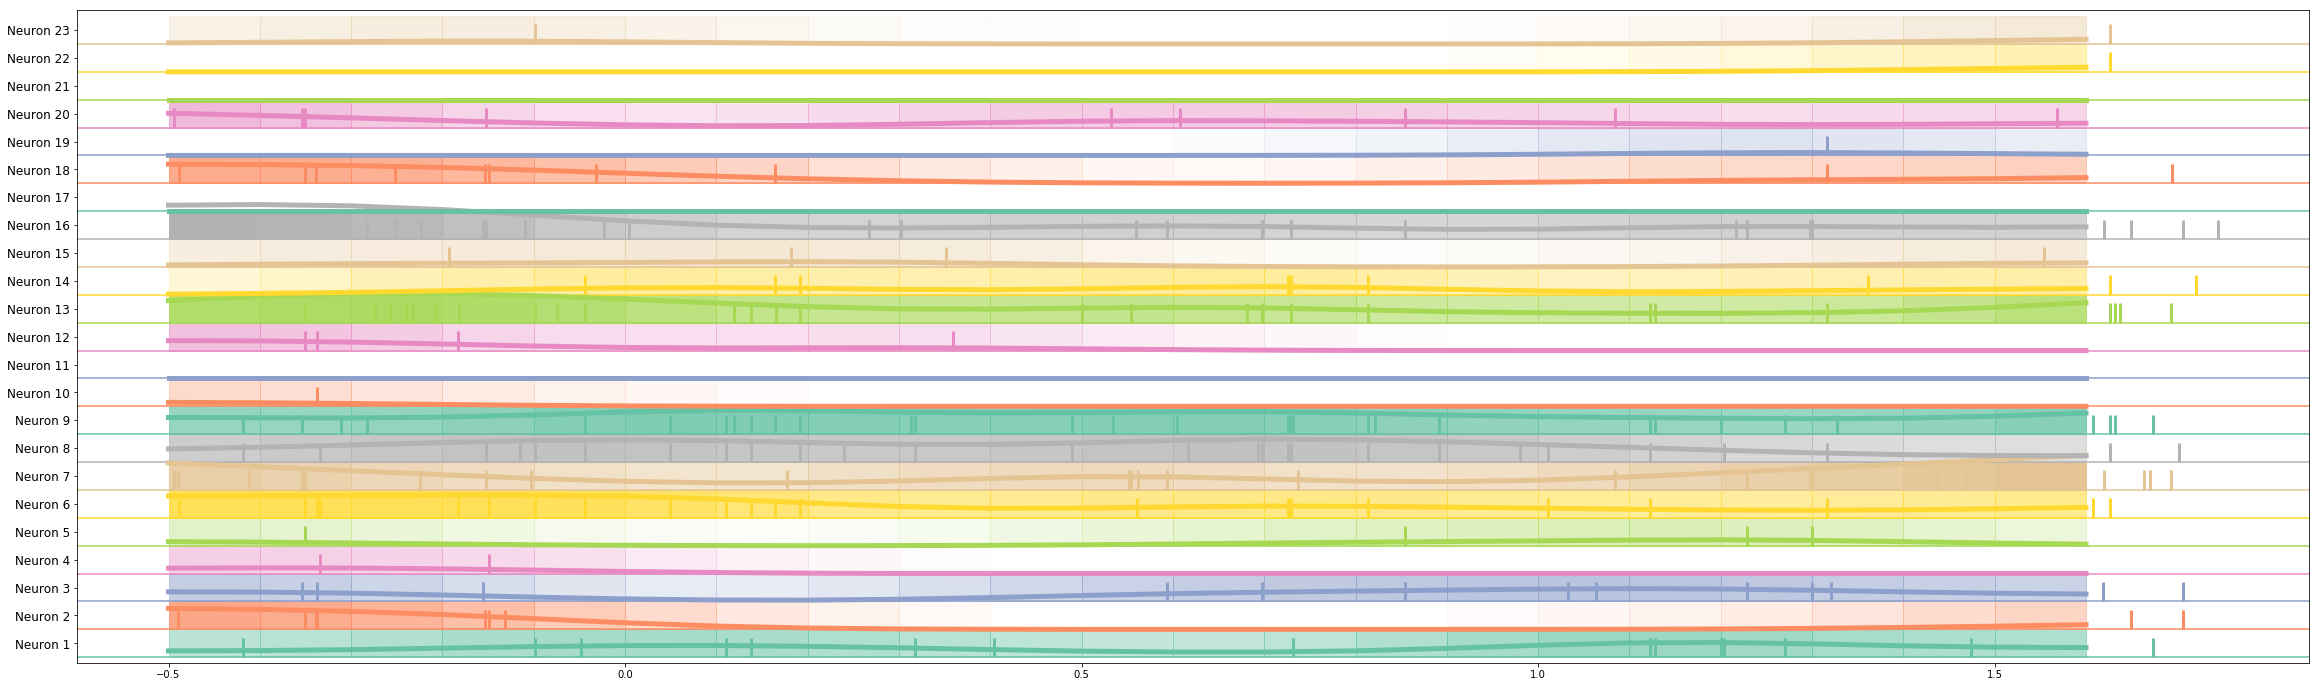

In [21]:
smk = spike_vector.loc[TRIAL].with_baseline.apply(lambda x: kernel_smooth(x*1000, sigma = 200, edges = (-500,1750), bin_size=100))
smk = pd.DataFrame(smk.tolist())

pretty_neurons(spike_vector=spike_vector.loc[TRIAL].with_baseline.values, rate = 1, tmin = -.6,tmax=spike_vector.loc[TRIAL,'duration'].values[0]+.1,
                   smooth=smk[0].values/2, times = smk[1].values/1000, fig_kwargs={'figsize':(40,12)}, bin_sep=0, bin_fill=(23,21));

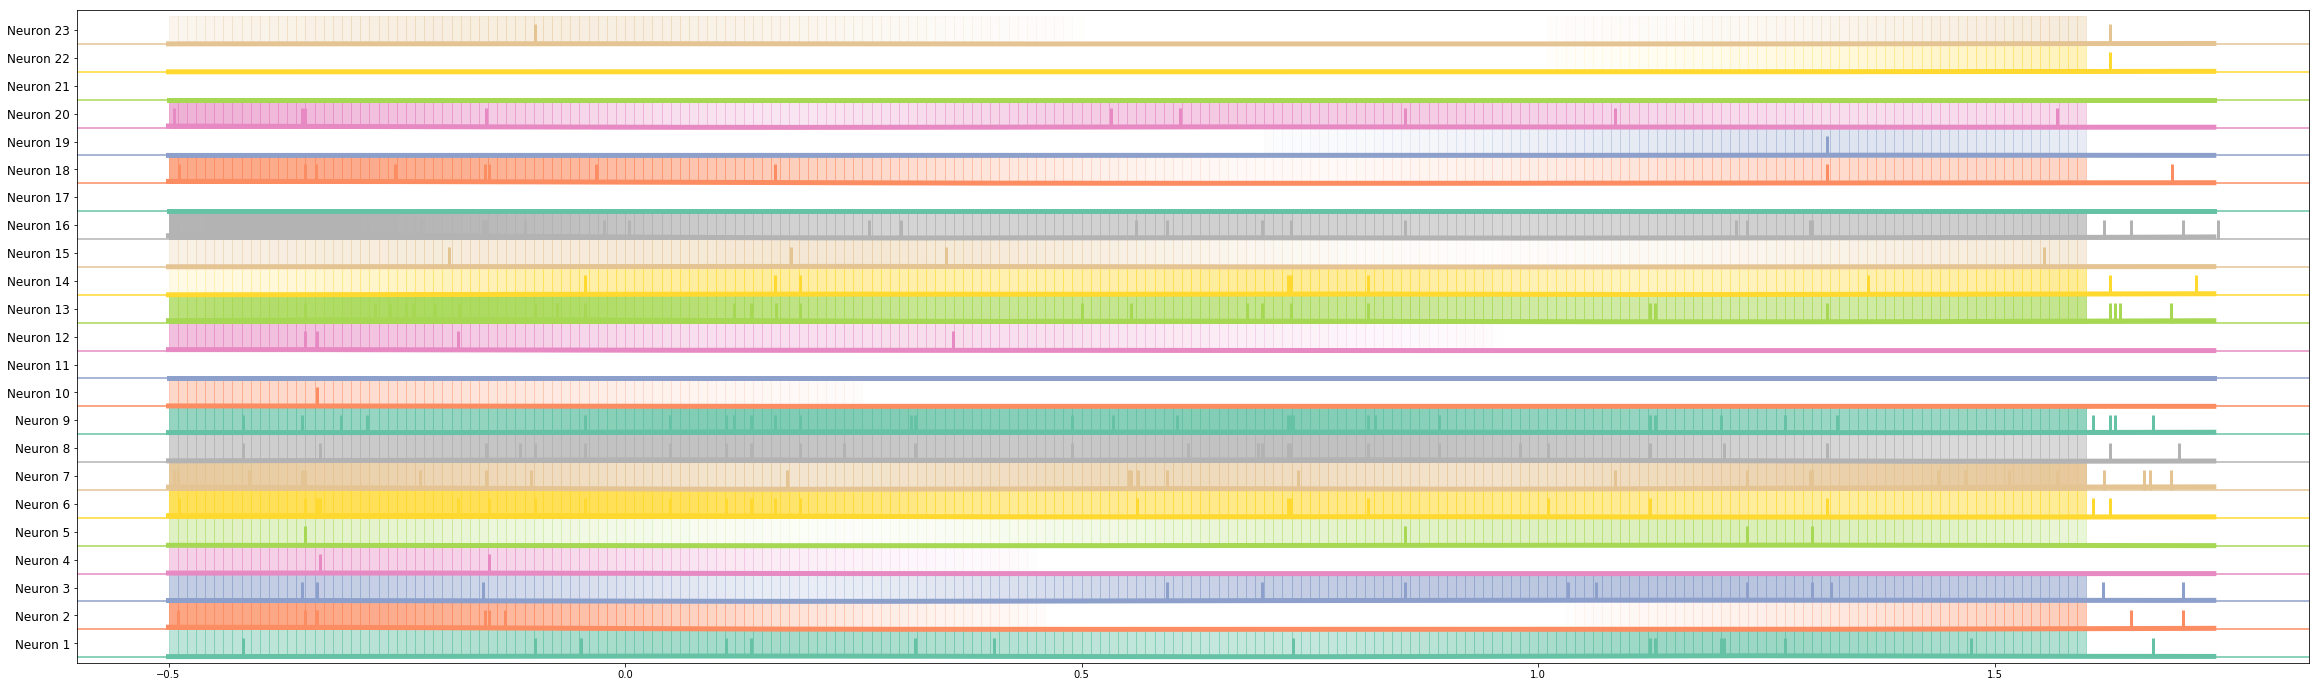

In [22]:
smk = spike_vector.loc[TRIAL].with_baseline.apply(lambda x: kernel_smooth(x*1000, sigma = 200, edges = (-500,1750), bin_size=10))
smk = pd.DataFrame(smk.tolist())

pretty_neurons(spike_vector=spike_vector.loc[TRIAL].with_baseline.values, rate = 1, tmin = -.6,tmax=spike_vector.loc[TRIAL,'duration'].values[0]+.1,
                   smooth=smk[0].values/2, times = smk[1].values/1000, fig_kwargs={'figsize':(40,12)}, bin_sep=0, bin_fill=(23,210));

## True data

In [ ]:
smk = spike_vector.loc[TRIAL].with_baseline.apply(lambda x: kernel_smooth(x*1000, sigma = 200, edges = (-500,1750), bin_size=10))
smk = pd.DataFrame(smk.tolist())

pretty_neurons(spike_vector=spike_vector.loc[TRIAL].with_baseline.values, rate = 1, tmin = -.6,tmax=spike_vector.loc[TRIAL,'duration'].values[0]+.1,
                   smooth=smk[0].values/2, times = smk[1].values/1000, fig_kwargs={'figsize':(40,12)}, bin_sep=0, bin_fill=(23,210));

---

# Firing rate and baseline

In [2]:
from collections import Counter

In [3]:
label, dset = 'DRRD 10', 'medium_smoothed'
r = io.load(label, 'spikes')
e = io.load(label, 'epoched_spikes')
s = io.load(label, dset)

In [4]:
spt_raw = r.trial.apply(np.unique, return_counts=True).apply(lambda x: dict(zip(*x)))
spt_epoched = e.with_baseline.apply(len).unstack('trial').apply(lambda x: dict(zip(x.index[x.values>0], x.values[x.values>0])),axis=1)
not any(spt_raw != spt_epoched)

True

In [94]:
import unittest
import numpy.testing as nt

nt.assert_array_equal()
class TestEpoching(unittest.TestCase):
    label, dset = 'DRRD 7', 'medium_smoothed'
    r = io.load(label, 'spikes')
    e = io.load(label, 'epoched_spikes')
    s = io.load(label, dset)
    
    def test_spike_count(self):
        spt_raw = r.trial.apply(np.unique, return_counts=True).apply(lambda x: dict(zip(*x)))
        spt_epoched = e.with_baseline.apply(len).unstack('trial').apply(lambda x: dict(zip(x.index[x.values>0], x.values[x.values>0])),axis=1)
        assert not any(spt_raw != spt_epoched)
        assert all(s.full.apply(np.sum)[e.with_baseline.apply(len)==0]==0)
        
    def test_isupper(self):
        duration = e.duration.unstack('trial').iloc[0]
        last_spike = e.with_baseline.apply(lambda x: np.max(x) if len(x)>0 else 0).unstack('trial').max()
        assert all(duration>last_spike)

    def test_split(self):
        pass

if __name__ == '__main__':
    unittest.main()

E
ERROR: /run/user/1000/jupyter/kernel-14ed81cb-3f64-4814-b376-f41e01f7ca3c (unittest.loader._FailedTest)
----------------------------------------------------------------------
AttributeError: module '__main__' has no attribute '/run/user/1000/jupyter/kernel-14ed81cb-3f64-4814-b376-f41e01f7ca3c'

----------------------------------------------------------------------
Ran 1 test in 0.001s

FAILED (errors=1)


SystemExit: True

/home/registroeletrofisio/miniconda3/envs/ratLearn/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [5]:
all(s.full.apply(np.sum)[e.with_baseline.apply(len)==0]==0)

True

In [7]:
nonzero_spikes = e.with_baseline.apply(len)!=0

In [8]:
sum_spikes_smooth = s.full.apply(np.sum)[nonzero_spikes]
spikes_epoch = e.with_baseline[nonzero_spikes]

props = (sum_spikes_smooth/spikes_epoch.apply(len))
p = pd.DataFrame(props,columns=['prop_fr'])
p['duration'] = props.reset_index().trial.map(e.reset_index().drop_duplicates('trial').set_index('trial').duration).values
p= p.join(spikes_epoch).join(sum_spikes_smooth)

In [9]:
p.sort_values('prop_fr')

prop_fr  duration  \
trial unit                       
890   79    0.000000  0.190751   
501   67    0.000000  1.194639   
      64    0.000000  1.194639   
      63    0.000000  1.194639   
      58    0.000000  1.194639   
      44    0.000000  1.194639   
      42    0.000000  1.194639   
68    32    0.000000  0.453263   
      33    0.000000  0.453263   
      47    0.000000  0.453263   
500   84    0.000000  3.212288   
      83    0.000000  3.212288   
      82    0.000000  3.212288   
      81    0.000000  3.212288   
68    65    0.000000  0.453263   
      81    0.000000  0.453263   
      82    0.000000  0.453263   
      83    0.000000  0.453263   
      84    0.000000  0.453263   
      85    0.000000  0.453263   
500   2     0.000000  3.212288   
499   93    0.000000  1.543127   
      92    0.000000  1.543127   
      88    0.000000  1.543127   
      86    0.000000  1.543127   
      21    0.000000  1.543127   
1102  38    0.000000  0.676741   
      39    0.000000  0.676741   
501   69    0.000000  1.194639   
1102  41    0.000000  0.676741   
...              ...       ...   
18    3     1.079307  0.548414   
693   77    1.079307  1.606779   
856   35    1.079307  1.701519   
1567  65    1.079307  2.228429   
1172  49    1.079312  1.657324   
1657  46    1.079312  0.223314   
1556  68    1.079312  3.345899   
741   48    1.079312  1.213645   
1181  42    1.079312  2.388623   
773   91    1.079312  1.704551   
1368  54    1.079312  2.679399   
773   89    1.079312  1.704551   
1383  80    1.079312  1.694515   
71    24    1.079312  0.185836   
155   3     1.079312  2.774262   
528   70    1.079312  4.670792   
1433  43    1.079344  1.978245   
559   33    1.079344  2.514903   
1261  80    1.079344  4.208272   
1031  52    1.079344  1.730969   
87    85    1.079344  1.712783   
1603  2     1.079344  2.614641   
366   63    1.079344  0.737362   
940   14    1.079344  0.898417   
366   66    1.079344  0.737362   
      67    1.079344  0.737362   
752   42    1.079344  3.130204   
1562  93    1.079344  2.781471   
1201  35    1.079344  2.288968   
96    32    1.079344  0.395387   

                                                with_baseline      full  
trial unit                                                               
890   79                     [0.185508012772, 0.188129425049]  0.000000  
501   67    [1.12771081924, 1.1309466362, 1.13442826271, 1...  0.000000  
      64                       [1.18554615974, 1.19042038918]  0.000000  
      63         [1.12779259682, 1.14638853073, 1.1903386116]  0.000000  
      58                                      [1.18554615974]  0.000000  
      44                                      [1.19046139717]  0.000000  
      42                       [1.18558716774, 1.19046139717]  0.000000  
68    32                                     [0.415006637573]  0.000000  
      33                                     [0.415006637573]  0.000000  
      47                                      [0.41512966156]  0.000000  
500   84                                       [3.2060213089]  0.000000  
      83                                       [3.2060213089]  0.000000  
      82                                       [3.2060213089]  0.000000  
      81                                       [3.2060213089]  0.000000  
68    65                     [0.413655042648, 0.415006637573]  0.000000  
      81                     [0.411197423935, 0.417095661163]  0.000000  
      82                     [0.411156415939, 0.417136669159]  0.000000  
      83                     [0.411156415939, 0.417095661163]  0.000000  
      84                     [0.411197423935, 0.417095661163]  0.000000  
      85                     [0.411156415939, 0.417095661163]  0.000000  
500   2                                       [3.20589828491]  0.000000  
499   93                                      [1.50736880302]  0.000000  
      92                                      [1.50740981102]  0.000000  
      88            

We want the firing rate to be in spikes per second. This means that the sum of firing_rate\*dt must be equal to the number of spikes in a trial.

Pseudo-problem: There are spikes in the final 'tail', and they are dumped prior to smoothing, because of the bin size. Make validation taking this into account.

In [87]:
p['n_spikes'] = p.with_baseline.apply(len)
p['n_spikes_accountable'] = p.

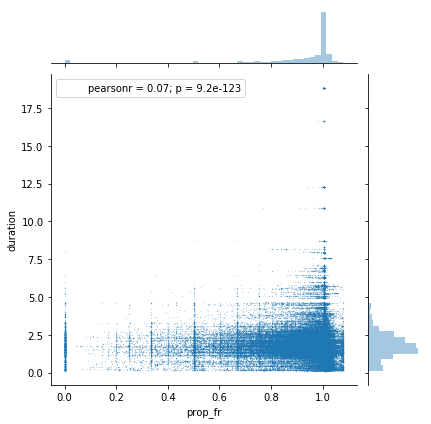

In [86]:
sns.jointplot('prop_fr','duration', data = p, s=.01)

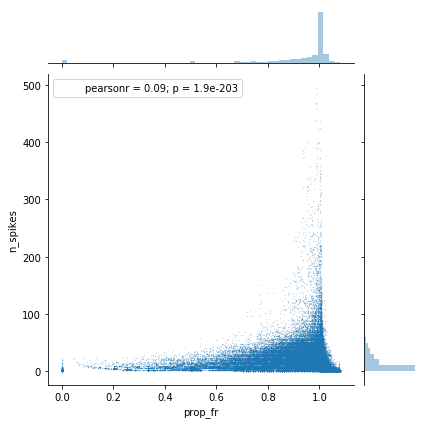

In [90]:
sns.jointplot('prop_fr','n_spikes', data = p, s=.01)

## Testando na mão

---

# Comparações

In [117]:
lene = e[['time', 'baseline']].applymap(len)

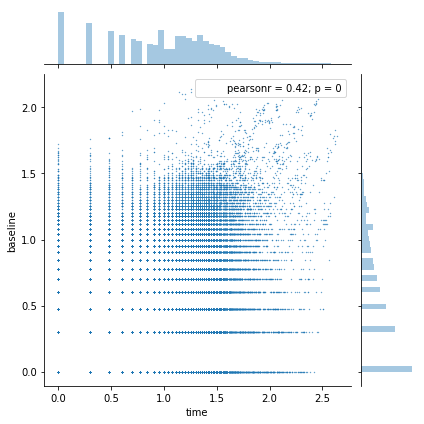

In [115]:
sns.jointplot(x='time', y='baseline', data=lene[(lene.time>0) & (lene.baseline>0)].applymap(lambda x: np.log10(x)), s=.1)

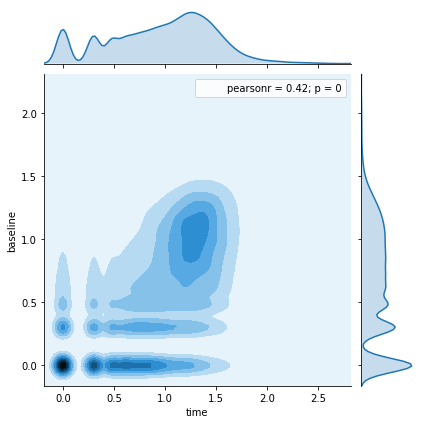

In [116]:
sns.jointplot(x='time', y='baseline', data=lene[(lene.time>0) & (lene.baseline>0)].applymap(lambda x: np.log10(x)), kind='kde')

## Multiplos paddings

In [117]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

sns.set_style()
plt.style.use('seaborn-pastel')
mpl.rcParams['axes.facecolor'] = (1,1,1,0)
mpl.rcParams['figure.facecolor'] = (1,1,1,0)

# Below my preferences, not related to background
mpl.rc("figure", figsize=(6,4))
mpl.rcParams['lines.linewidth'] = 2
sns.set_palette('deep', color_codes=True)

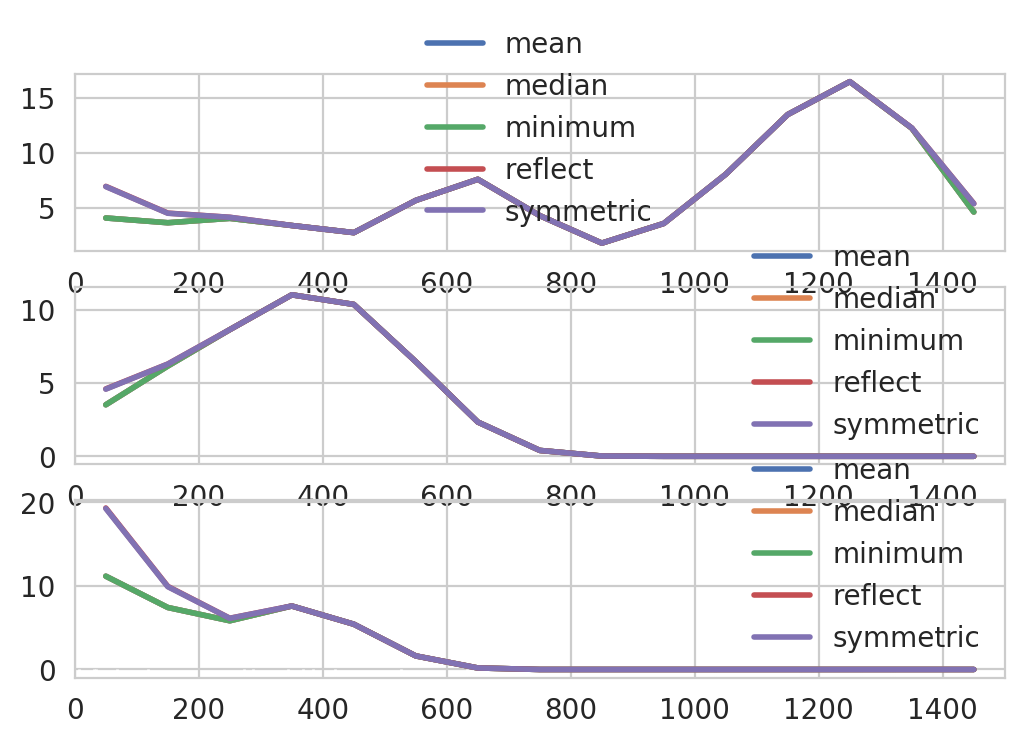

In [118]:

fig, ax= plt.subplots(3, dpi=200)
for i in range(3):
    vec = epoch.loc[(i+1,0), 'time']*1000
    for pad in ['mean', 'median', 'minimum', 'reflect', 'symmetric']:
        smooth = kernel_smooth(vec, sigma=100, edges=(0,1500), bin_size=100, padding=pad)
        ax[i].plot(smooth[1]+50,smooth[0], label=pad)
    sns.rugplot(vec);
    ax[i].legend(frameon=False)
    ax[i].set_xlim(0,1500)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


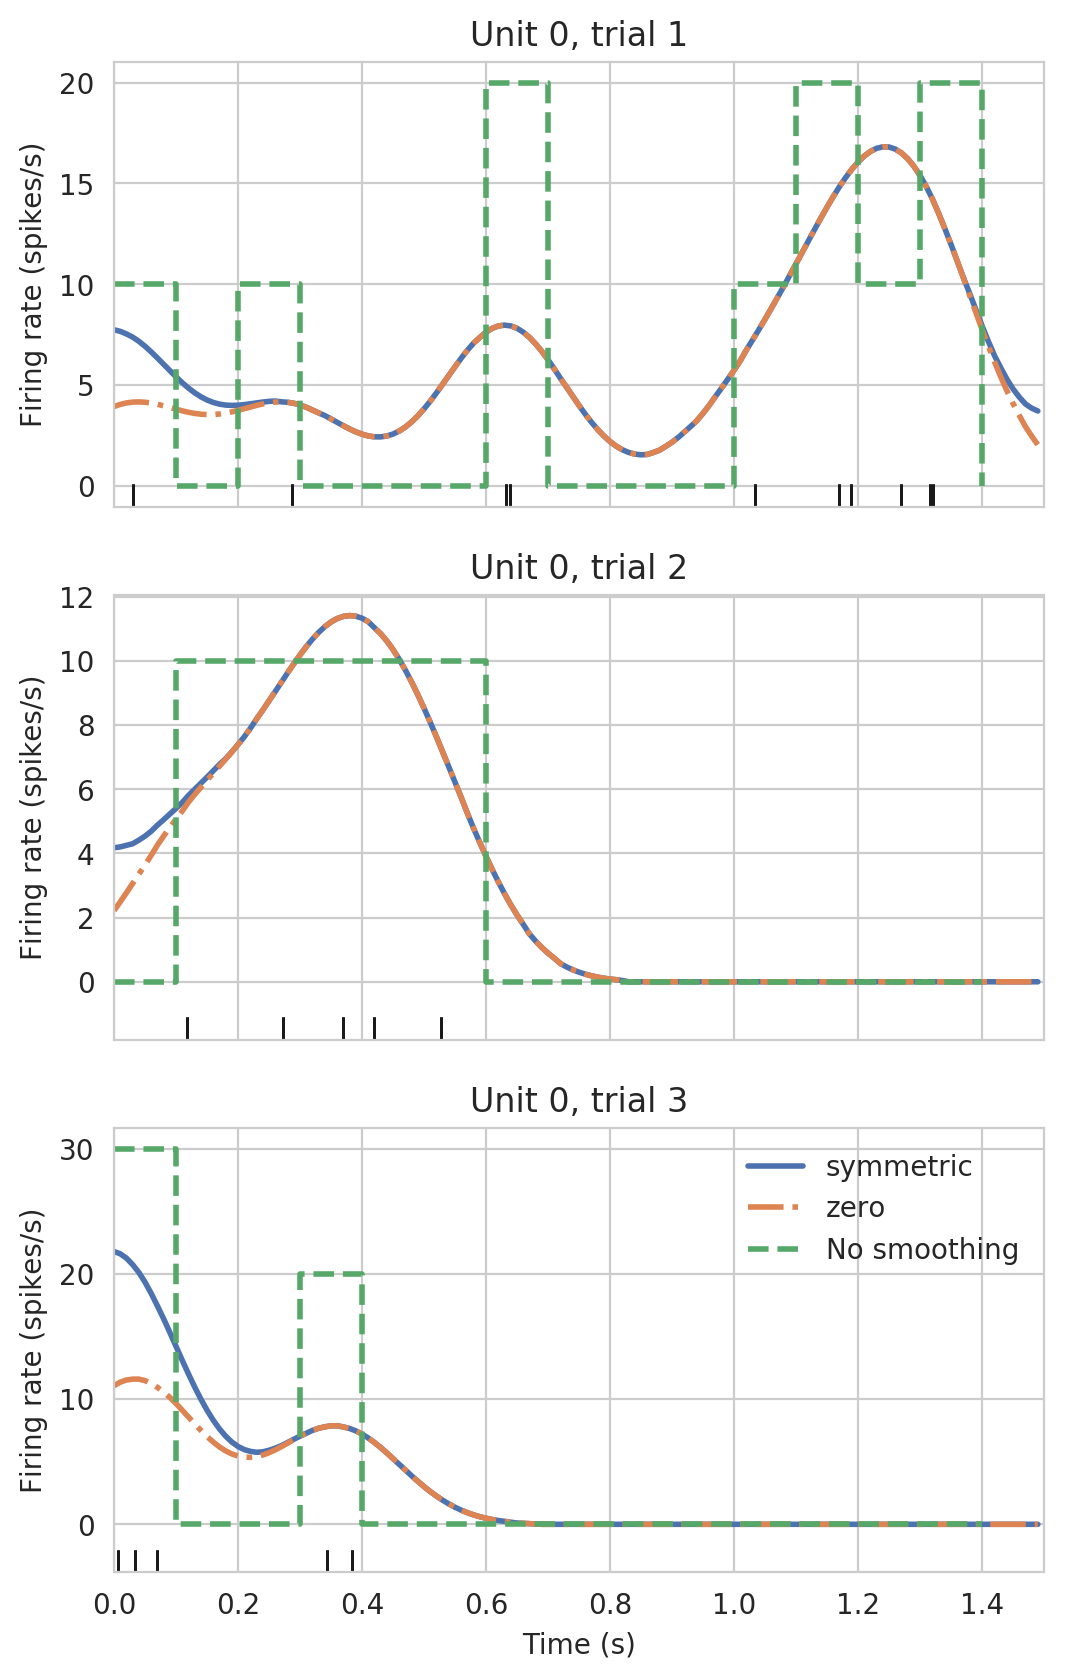

In [144]:

fig, ax= plt.subplots(3, dpi=200, figsize=(6,10), sharex=True)
styles = ['-', '-.', '--', ':']
for i in range(3):
    vec = epoch.loc[(i+1,0), 'time']*1000
    for p, pad in enumerate(['symmetric', 'zero',  'No smoothing']):
        if pad == 'No smoothing':
            smooth = kernel_smooth(vec, sigma=None, edges=(0,1500), bin_size=100, padding=None if pad is 'zero' else pad)
            ax[i].step((smooth[1][:-1])/1000, smooth[0]*10, label=pad, linestyle = styles[p], where='post')
        else:
            smooth = kernel_smooth(vec, sigma=100, edges=(0,1500), bin_size=10, padding=None if pad is 'zero' else pad)
            ax[i].plot((smooth[1])/1000,smooth[0], label=pad, linestyle = styles[p])
        ax[i].set_title('Unit 0, trial %d'%(i+1))
        ax[i].set_ylabel('Firing rate (spikes/s)')
        sns.rugplot(vec/1000, ax=ax[i], color='k');
    ax[2].legend(frameon=False)
    ax[2].set_xlabel('Time (s)')
    ax[i].set_xlim(0,1.5)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


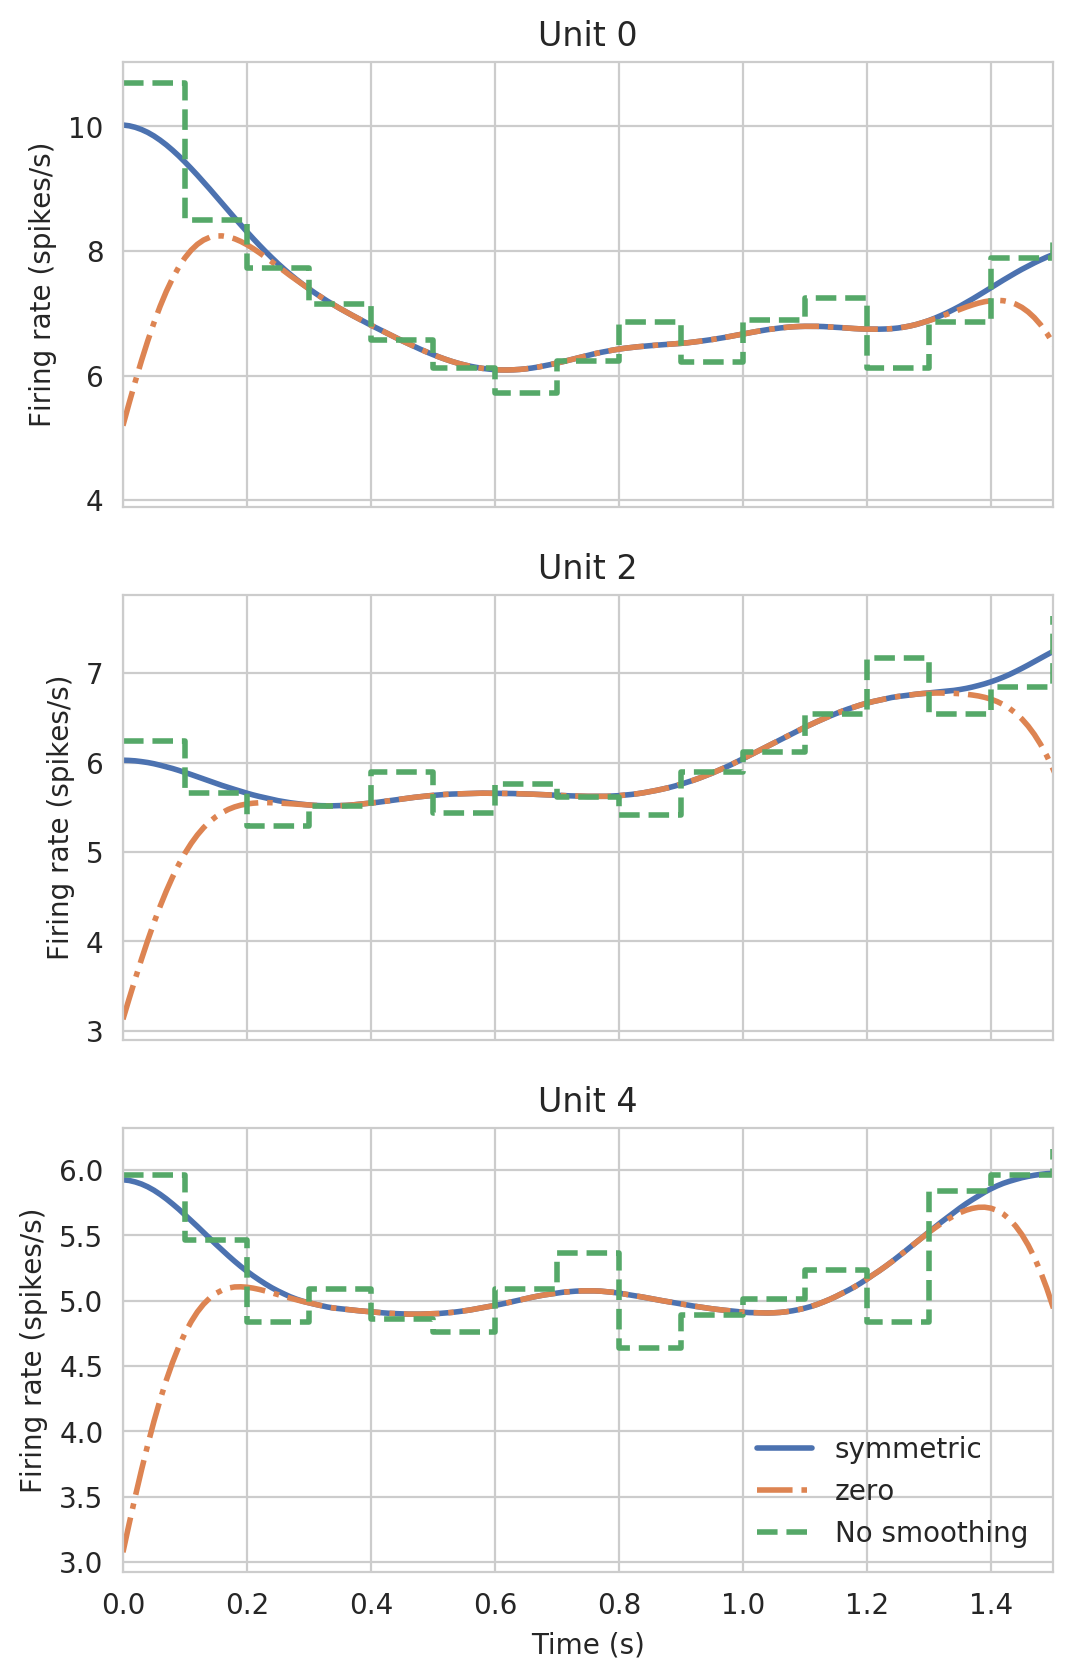

In [146]:

fig, ax= plt.subplots(3, dpi=200, figsize=(6,10), sharex=True)
styles = ['-', '-.', '--', ':']
for i in range(3):
    for p, pad in enumerate(['symmetric' , 'zero', 'No smoothing']):
        one_unit = epoch.reset_index().set_index(['unit']).loc[i*2]
        if pad == 'No smoothing':
            smooth = one_unit[one_unit.duration>1.6]\
                        .time.apply(lambda x: x*1000).apply(kernel_smooth, sigma=None, edges=(0,1600), bin_size=100)
            time = smooth.iloc[0][1][:-1]/1000
            smooth = np.vstack(smooth.apply(lambda x: x[0]).values).mean(axis=0)*10
            ax[i].step(time,smooth, label=pad, linestyle = styles[p], where='post')
        else:
            smooth = one_unit[one_unit.duration>1.6]\
                        .time.apply(lambda x: x*1000).apply(kernel_smooth, sigma=100, edges=(0,1600), bin_size=10, 
                                                            padding=None if pad is 'zero' else pad)
            time = smooth.iloc[0][1]/1000
            smooth = np.vstack(smooth.apply(lambda x: x[0]).values).mean(axis=0)
            ax[i].plot(time,smooth, label=pad, linestyle = styles[p])
        ax[i].set_title('Unit %d'%(i*2))
        ax[i].set_ylabel('Firing rate (spikes/s)')
    ax[2].legend(frameon=False)
    ax[2].set_xlabel('Time (s)')
    ax[i].set_xlim(0,1.5)